# Export LaMa inpainting model to ONNX


Author: [Nikita Selin](https://github.com/OPHoperHPO), [Carve.Photos Team](https://carve.photos) \
HuggingFace Repository with ONNX Model: [Link](https://huggingface.co/Carve/LaMa-ONNX) \
Original repository: [Link](https://github.com/advimman/lama)




## install deps

In [1]:
!git clone https://github.com/Carve-Photos/lama --depth 1

Cloning into 'lama'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 249 (delta 53), reused 134 (delta 48), pack-reused 0 (from 0)
Receiving objects: 100% (249/249), 5.68 MiB | 7.37 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
%cd lama

/content/lama


In [3]:
!curl -LJO https://huggingface.co/smartywu/big-lama/resolve/main/big-lama.zip
!unzip big-lama.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1171  100  1171    0     0   5660      0 --:--:-- --:--:-- --:--:--  5684
100  363M  100  363M    0     0   109M      0  0:00:03  0:00:03 --:--:--  117M
Archive:  big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [4]:
!pip3 install omegaconf webdataset pytorch_lightning pytorch_lightning kornia==0.5.0 onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.5/271.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
 

## init model

In [1]:
pip install albumentations==0.5.2

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.25.2
 # Reinstall numpy 1.26.3 to ensure imgaug uses a compatible numpy version

In [2]:
!cd /content/lama

## Export onnx

In [3]:
!pip3 install omegaconf webdataset pytorch_lightning pytorch_lightning kornia==0.5.0 onnx onnxruntime

##Create a export object

In [4]:
import torch
from omegaconf import OmegaConf
from yaml import safe_load
import sys
sys.path.append("/content/lama")

from saicinpainting.training.trainers.default import (
    DefaultInpaintingTrainingModule,
)


class ExportLama(torch.nn.Module):
    def forward(self, image: torch.Tensor, mask: torch.Tensor):
        masked_img = image * (1 - mask)

        if self.model.concat_mask:
            masked_img = torch.cat([masked_img, mask], dim=1)

        predicted_image = self.model.generator(masked_img)
        inpainted = mask * predicted_image + (1 - mask) * image
        return torch.clamp(inpainted * 255, min=0, max=255)

Detectron v2 is not installed


In [5]:
# Load the configuration file
config = OmegaConf.create(safe_load(open("/content/lama/big-lama/config.yaml")))

# Extract and modify training model configuration
kwargs = dict(config.training_model)
kwargs.pop("kind")
kwargs["use_ddp"] = True

# Enable JIT version of FourierUnit, required for export
config.generator.resnet_conv_kwargs.use_jit = True

# Fix the configuration by setting the weight to zero
config.losses.resnet_pl.weight = 0

# Load the model state
state = torch.load("/content/lama/big-lama/models/best.ckpt", map_location="cpu", weights_only =False )
lama_dilated_model = DefaultInpaintingTrainingModule(config, **kwargs)
lama_dilated_model.load_state_dict(state["state_dict"], strict=False)
lama_dilated_model.on_load_checkpoint(state)
lama_dilated_model.freeze()
lama_dilated_model.eval()

# Export the model
exported_model = ExportLama()
exported_model.register_module("model", lama_dilated_model)
exported_model.eval()
exported_model.to("cpu")

# Export to ONNX format
torch.onnx.export(
    exported_model,
    (
        torch.rand(1, 3, 512, 512).type(torch.float32).to("cpu"),  # Change resolution here! If you get a tensor size mismatch, you need to specify correct padding (see FourierUnitJIT)
        torch.rand(1, 1, 512, 512).type(torch.float32).to("cpu")
    ),
    "/content/lama_fp32.onnx",
    input_names=["image", "mask"],
    output_names=["output"],
    dynamic_axes={
        "image": {0: "batch"},
        "mask": {0: "batch"},
        "output": {0: "batch"}
    },  # TODO: Adapt FourierUnit to support dynamic axes (see irfttn and rfft for correct padding)
    export_params=True,
    do_constant_folding=True,
    opset_version=17,
    verbose=False,
)

print("Lama Model exported to /content/lama_fp32.onnx (open file explorer to download)")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 78.5MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.

Lama Model exported to /content/lama_fp32.onnx (open file explorer to download)


In [15]:
!pip install --upgrade onnxruntime



##Following tuning will crash the kernel

In [ ]:
"""

quantize_static(
        model_fp32_path,                  # Path to the FP32 model
        quantized_model_path,             # Path to save the quantized model
        calibration_reader,               # Your calibration data reader
        weight_type=QuantType.QUInt8      # Quantizing weights to INT8
    ) is very slow and crash the session what to do
"""

In [6]:
import cv2
import numpy as np
import onnxruntime
import torch
import io
import requests
from PIL import Image

def get_image(image):
    if isinstance(image, Image.Image):
        img = np.array(image)
    elif isinstance(image, np.ndarray):
        img = image.copy()
    else:
        raise Exception("Input image should be either PIL Image or numpy array!")

    if img.ndim == 3:
        img = np.transpose(img, (2, 0, 1))  # chw
    elif img.ndim == 2:
        img = img[np.newaxis, ...]

    assert img.ndim == 3

    img = img.astype(np.float32) / 255
    return img


def ceil_modulo(x, mod):
    if x % mod == 0:
        return x
    return (x // mod + 1) * mod


def scale_image(img, factor, interpolation=cv2.INTER_AREA):
    if img.shape[0] == 1:
        img = img[0]
    else:
        img = np.transpose(img, (1, 2, 0))

    img = cv2.resize(img, dsize=None, fx=factor, fy=factor, interpolation=interpolation)

    if img.ndim == 2:
        img = img[None, ...]
    else:
        img = np.transpose(img, (2, 0, 1))
    return img


def pad_img_to_modulo(img, mod):
    channels, height, width = img.shape
    out_height = ceil_modulo(height, mod)
    out_width = ceil_modulo(width, mod)
    return np.pad(
        img,
        ((0, 0), (0, out_height - height), (0, out_width - width)),
        mode="symmetric",
    )


def prepare_img_and_mask(image, mask, device, pad_out_to_modulo=8, scale_factor=None):
    out_image = get_image(image)
    out_mask = get_image(mask)

    if scale_factor is not None:
        out_image = scale_image(out_image, scale_factor)
        out_mask = scale_image(out_mask, scale_factor, interpolation=cv2.INTER_NEAREST)

    if pad_out_to_modulo is not None and pad_out_to_modulo > 1:
        out_image = pad_img_to_modulo(out_image, pad_out_to_modulo)
        out_mask = pad_img_to_modulo(out_mask, pad_out_to_modulo)

    out_image = torch.from_numpy(out_image).unsqueeze(0).to(device)
    out_mask = torch.from_numpy(out_mask).unsqueeze(0).to(device)

    out_mask = (out_mask > 0) * 1

    return out_image, out_mask

def open_image(image):
    if isinstance(image, str):
      if image.startswith("http://") or image.startswith("https://"):
        image = Image.open(io.BytesIO(requests.get(image).content))
      else:
        image = Image.open(image)
    return image





##How to make a 16 float of the model.

In [9]:
import onnxruntime

In [13]:
pip install onnx onnxconverter-common

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.17.0 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.2 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.2 which is incompatible

In [1]:
 import onnx
 from onnxconverter_common import float16

 model = onnx.load("/content/lama_fp32.onnx")
 model_fp16 = float16.convert_float_to_float16(model)
 onnx.save(model_fp16, "/content/model_fp16.onnx")

/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:40: UserWarning: the float32 number 484322.5625 will be truncated to 10000.0
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_max, max_finite_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:40: UserWarning: the float32 number 28090.654296875 will be truncated to 10000.0
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_max, max_finite_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 3.151276573021278e-08 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_min, min_positive_val))
/usr/local/lib/python3.11/dist-packages/onnxconverter_common/float16.py:40: UserWarning: the float32 number 174809.921875 will be truncated to 10000.0
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_max, max_finite_val))


In [3]:
import onnxruntime

In [4]:
sess_options = onnxruntime.SessionOptions()
model = onnxruntime.InferenceSession('/content/model_fp16.onnx', sess_options=sess_options)

Inference time: 10.242142915725708 seconds


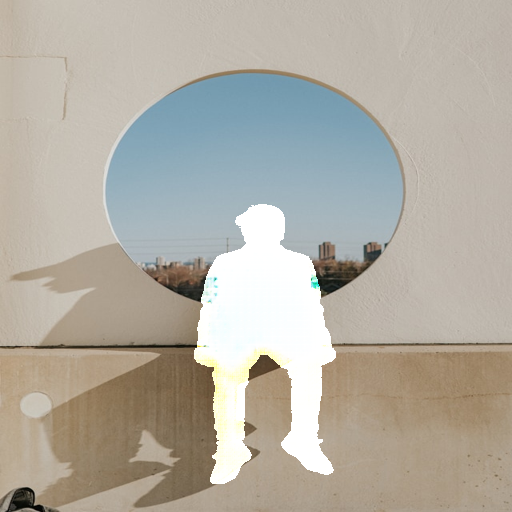

In [9]:
import time
#@title predict with onnx fp16 model
image_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/image.jpg" # @param {type:"string"}
mask_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/mask.png" # @param {type:"string"}

image = open_image(image_url).resize((512, 512))
mask = open_image(mask_url).convert("L").resize((512, 512))

image, mask = prepare_img_and_mask(image, mask, 'cpu')
# Run the model
start_time = time.time()
# Change the input data type to float16
outputs = model.run(None,
                    {'image': image.numpy().astype(np.float16), # Changed to np.float16
                     'mask': mask.numpy().astype(np.float16)})  # Changed to np.float16
print(f"Inference time: {time.time() - start_time} seconds")
output = outputs[0][0]
# Postprocess the outputs
output = output.transpose(1, 2, 0)
output = output.astype(np.uint8)
output = Image.fromarray(output)
output

##Not Accurate at all

##Make a calibrated version of the ONNX model

In [1]:
import numpy as np
import onnx
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType

# Load the FP32 model
model_fp32_path = "/content/lama_fp32.onnx"
model = onnx.load(model_fp32_path)

# Define a custom calibration dataset reader (you need to provide this)
class MyCalibrationReader(CalibrationDataReader):
    def __init__(self, data):
        self.data = data
        self.index = 0

    def get_next(self):
        if self.index < len(self.data):
            # Return the next batch for calibration (adjust this based on your data)
            # The input to the model is expected to be a dictionary
            image_batch = self.data[self.index][0]  # Get image data
            mask_batch = self.data[self.index][1]  # Get mask data
            self.index += 1
            return {'image': image_batch, 'mask': mask_batch}  # Return as a dictionary
        return None

    def reset(self):
        self.index = 0

# Example calibration data - This needs to be replaced with your actual dataset
# Assuming the model expects image and mask inputs of size 512x512
calibration_data = [
    # Each item in the list should be a tuple of (image_batch, mask_batch)
    (np.random.randn(1, 3, 512, 512).astype(np.float32),  # Example image batch (1x3x512x512)
     np.random.randn(1, 1, 512, 512).astype(np.float32)),  # Example mask batch (1x1x512x512)
    (np.random.randn(1, 3, 512, 512).astype(np.float32),  # Another example image batch
     np.random.randn(1, 1, 512, 512).astype(np.float32))   # Another example mask batch
]

# Create a calibration reader with the actual data
calibration_reader = MyCalibrationReader(calibration_data)

# Perform static quantization with calibration
quantized_model_path = "/content/lama_quantized_calibrated.onnx"
try:
    from onnxruntime.quantization import quantize_dynamic
    quantize_dynamic(
        model_fp32_path,
        quantized_model_path,
        weight_type=QuantType.QUInt8
    )

    print(f"Quantized and calibrated model saved at: {quantized_model_path}")
except Exception as e:
    print(f"An error occurred during quantization: {e}")


  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_value: 4
    }
    dim {
   

Quantized and calibrated model saved at: /content/lama_quantized_calibrated.onnx


##Load the calibrated model and infere

In [10]:
sess_options = onnxruntime.SessionOptions()
model = onnxruntime.InferenceSession('/content/lama_quantized_calibrated.onnx', sess_options=sess_options)

Inference time: 10.316220760345459 seconds


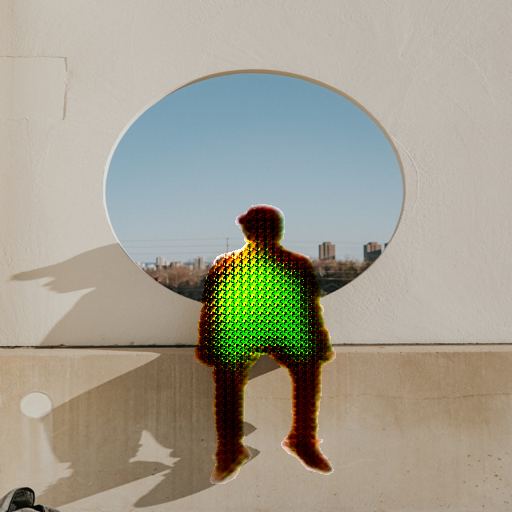

In [11]:
import time
#@title predict with onnx model
image_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/image.jpg" # @param {type:"string"}
mask_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/mask.png" # @param {type:"string"}

image = open_image(image_url).resize((512, 512))
mask = open_image(mask_url).convert("L").resize((512, 512))

image, mask = prepare_img_and_mask(image, mask, 'cpu')
# Run the model
start_time = time.time()
outputs = model.run(None,
                    {'image': image.numpy().astype(np.float32),
                     'mask': mask.numpy().astype(np.float32)})
print(f"Inference time: {time.time() - start_time} seconds")
output = outputs[0][0]
# Postprocess the outputs
output = output.transpose(1, 2, 0)
output = output.astype(np.uint8)
output = Image.fromarray(output)
output

## Now lets create a 8 bit quantized model.

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

# Load the model that was exported (lama_fp32.onnx)
onnx_model = onnx.load("/content/lama_fp32.onnx")

# Perform dynamic quantization with INT8 weights
quantized_model_path = "/content/lama_int8.onnx"
quantize_dynamic(
    "/content/lama_fp32.onnx",  # Path to the exported FP32 ONNX model
    quantized_model_path,       # Path to save the quantized model
    weight_type=QuantType.QUInt8  # Quantizing weights to INT8
)

print(f"Quantized model saved at: {quantized_model_path}")


## Test exported onnx model

In [ ]:
sess_options = onnxruntime.SessionOptions()
model = onnxruntime.InferenceSession('/content/lama_int8.onnx', sess_options=sess_options)

Inference time: 8.793294191360474 seconds


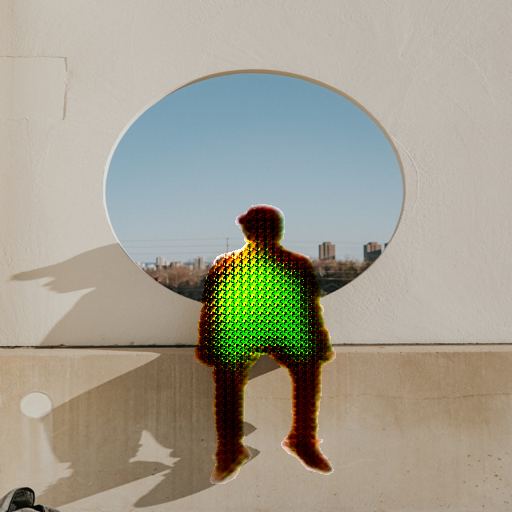

In [24]:
import time
#@title predict with onnx model
image_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/image.jpg" # @param {type:"string"}
mask_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/mask.png" # @param {type:"string"}

image = open_image(image_url).resize((512, 512))
mask = open_image(mask_url).convert("L").resize((512, 512))

image, mask = prepare_img_and_mask(image, mask, 'cpu')
# Run the model
start_time = time.time()
outputs = model.run(None,
                    {'image': image.numpy().astype(np.float32),
                     'mask': mask.numpy().astype(np.float32)})
print(f"Inference time: {time.time() - start_time} seconds")
output = outputs[0][0]
# Postprocess the outputs
output = output.transpose(1, 2, 0)
output = output.astype(np.uint8)
output = Image.fromarray(output)
output

## Congratulations we created different types of quantization with onnx.